## HeartBD2K Data Science Internship Fall 2017
### Priyanka Nanayakkara

The goal of the following project is to analyze time expressions (for example: "2 years later," "daily") in case reports on PubMed. To extract time expressions from the text, I used SUTime (http://nlp.stanford.edu:8080/sutime/process) and a Python wrapper for SUTime (https://github.com/FraBle/python-sutime).

SUTime returns annotations as JSON objects. The following reads in the annotations and adds them to a dataframe.

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from statistics import mean,median

############### Importing data ######################
# Case Reports part A
with open('./time_expressions_part_a.txt', encoding = 'utf-8') as json_file:
    data = json.load(json_file)

ann1 = data['annotations']

df = pd.DataFrame()

for i in range(0,100):
    temp = pd.read_json(ann1[i])
    temp['case_report'] = [i] * len(temp)
    df = df.append(temp)

# Case Reports part B
with open('./time_expressions_part_b.txt', encoding = 'utf-8') as json_file:
    data2 = json.load(json_file)

ann2 = data2['annotations']

df2 = pd.DataFrame()

for i in range(0,100):
    temp = pd.read_json(ann2[i])
    CR = i + 100
    temp['case_report'] = [CR] * len(temp)
    df2 = df2.append(temp)

ann = df.append(df2)
ann = ann.reset_index(drop=True) # number indices

There were 1732 time phrases picked up by SUTime in 200 case reports.

In [3]:
############### Exploring ###############################

# How many annotations?
len(ann)

1732

The mean number of time phrases per case report was 8.66, while the median was 7.

In [11]:
cr_counts=Counter(ann['case_report'])

mean(cr_counts.values())

8.66

In [12]:
median(cr_counts.values())

7.0

To get a better sense of the distribution of phrases per case report, see the histogram below.
The distribution is skewed right.

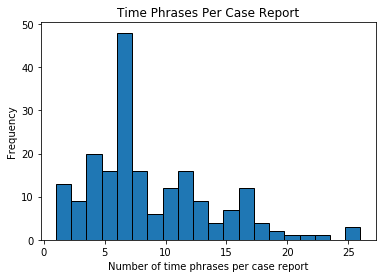

In [13]:
# histogram of time phrases per case report
plt.hist(cr_counts.values(),bins=20,histtype='bar',ec='black')
plt.xlabel('Number of time phrases per case report')
plt.ylabel('Frequency')
plt.title('Time Phrases Per Case Report')
plt.show()

SUTime labels time phrases with one of four values: DATE, DURATION, SET, TIME.
<br>
<br>
An example of each from this data are as follows:
<br>
<br>
-DATE: March 2011
<br>
-DURATION: 12 months 
<br>
-SET: daily 
<br>
-TIME: one in the evening

The number of each category of time phrase is below.

In [19]:
types=Counter(ann['type'])
types

Counter({'DATE': 526, 'DURATION': 1035, 'SET': 133, 'TIME': 38})

DURATION is clearly the most common type of annotation in this dataset.

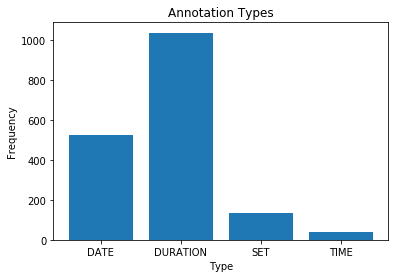

In [20]:
plt.bar(types.keys(),types.values())
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.title('Annotation Types')
plt.show()